# "Spiking Out" in advance of Friday OH

Goals
* Make sure my understanding is deep while not getting overly stuck in the nitty gritty
* Clear up lingering conceptual gaps: rate of return vs yield, "bond performance"
* Get some indicator-specific questions answered
* Get some advice on apples to apples/oranges comparison
* Get some advice on now picking 3 indicators

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

countries = CountryMetaDataFile().readMetadata()
dl = DataLib("SignalData")

# 0. Context on my first steps

First I tried to map the relationships between indicators using cause/effect, parallel/perpendicular, and other arrows. I was hoping this would give me some clarity on how each indicator worked, but it was confusing. 

Then I reapproached and tried to think at a higher level about what information I wanted to extract from my indicators. I thought I could group indicators based on whether they were slower/faster, whether they told me more about domestic/international conditions, or whether their information came from the market or elsewhere. This approach too ended up being overcomplicated and confusing.

I tried and failed to run my indicator search by diving logic/thinking-headfirst. This is my re-reapproach.

# 1. Understanding my goal

I want to solidify my sense of bond return index vs. bond returns vs. bond yields. Let me graph these and think through them a bit more.

In [63]:
BondReturnIndex = dl.pull('BondRetIdx/LocalFX') # daily, represents accumulated returns from holding 10-year bonds
MonthlyBondReturnIndex = BondReturnIndex.resample('1M').mean()
LongRates = dl.pull('LongRates') # monthly, nominal yield on 10-year govenment issued bonds

# INTUITION/EXPECTATION CHECK
# The higher the risk, the higher the yield --> conceptual example: bond risk premium expected to be positive
# The higher the ytm, the lower the price --> because ytm/price give same information
# The lower the price, the higher the yearly return --> consider 5$ coupon, if bond price falls, return is higher

# Long rate is % return offered each year from holding 10-yr bonds --> bond yield

country = 'USA'
average = 'Equal Weighted Mean'
BondReturnIndex[average] = BondReturnIndex.mean(axis=1)

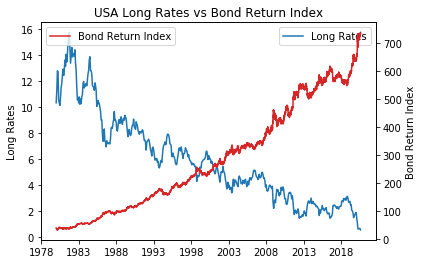

In [64]:
# Long Rates (Bond Yields) vs Bond Return Index
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Long Rates'
ax1.plot(LongRates[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Long Rates vs Bond Return Index')
plt.show()

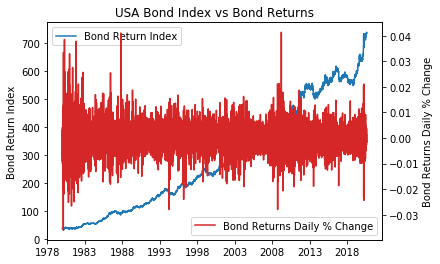

In [65]:
# Bond Return Index vs Bond Rate of Return
# TAKEAWAY: The index gives me a sense of how bond returns are changing/growing over time (patterns, trends).
# The rate of return (% change of index) is what I'll use to calculate P&L curve later on.
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Return Index'
ax1.plot(BondReturnIndex[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Returns Daily % Change'
ax2.plot(BondReturnIndex[country].pct_change().to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Index vs Bond Returns')
plt.show()

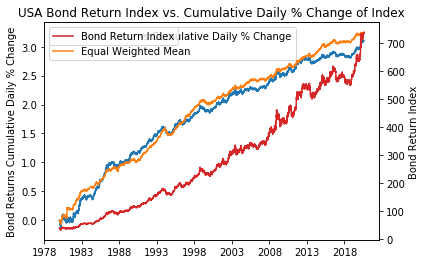

In [66]:
# Visualizing Bond Return Index vs. Cumulative Daily % Change of Index
# TAKEAWAY: I understand that accumulated % change and logging the index give me two other ways of thinking 
# about its behaviour over time.
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Returns Cumulative Daily % Change'
ax1.plot(BondReturnIndex[country].pct_change().cumsum().to_timestamp(), label = ax1_label)
ax1.plot(BondReturnIndex[average].pct_change().cumsum().to_timestamp())
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Return Index vs. Cumulative Daily % Change of Index')
plt.show()

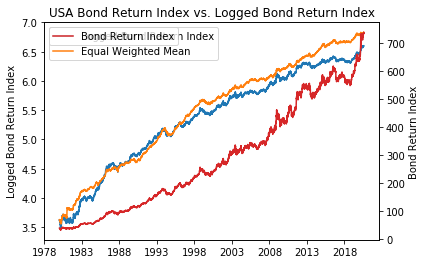

In [67]:
# Visualizing Bond Return Index vs. Logged Bond Return Index
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Logged Bond Return Index'
ax1.plot(np.log(BondReturnIndex[country]).to_timestamp(), label = ax1_label)
ax1.plot(np.log(BondReturnIndex[average]).to_timestamp())
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Return Index vs. Logged Bond Return Index')
plt.show()

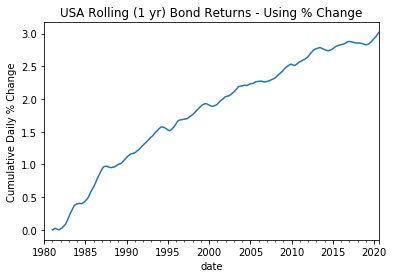

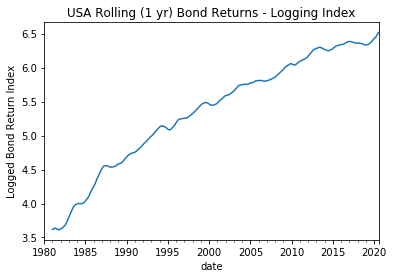

In [68]:
# Rolling Bond Returns
WEEKDAYS_IN_YEAR = 261

BondReturnIndex[country].pct_change().rolling(WEEKDAYS_IN_YEAR).mean().cumsum().plot()
plt.title(f'{country} Rolling (1 yr) Bond Returns - Using % Change')
plt.ylabel('Cumulative Daily % Change')
plt.show()

np.log(BondReturnIndex[country]).rolling(WEEKDAYS_IN_YEAR).mean().plot()
plt.title(f'{country} Rolling (1 yr) Bond Returns - Logging Index')
plt.ylabel('Logged Bond Return Index')
plt.show()

# 2. Starting simple and using charts to explore indicators

From my first steps, I think I want to pick Bond Premium, Curve Height, and FX Appreciation. From the Prospectus, it seemed to me indicators other than Change in GDP and Monetary Base would be most useful. Looking at the remaining 5, I thought that FX Appreciation and Current Account/GDP might have overlapping information. I'm going to try to test this idea. I also wasn't sure how important Relative Stock/Bond Performance might be. Also planning on testing it.

In [8]:
ShortRates = dl.pull('ShortRates') # monthly
EquityPrices = dl.pull('EquityPrices') # daily
M2inUSD = dl.pull('M2/inUSD') # monthly
CurrAcctNominUSD = dl.pull('CurrAcctNom/inUSD') # quarterly
CurrAcctPctGDP = dl.pull('CurrAcctPctGDP') # quarterly
GDPNominal = dl.pull('GDP/Nominal') # quarterly
GDPReal = dl.pull('GDP/Real') # quarterly
fxTrdWtsNominal = dl.pull('fxTrdWts/Nominal') # monthly
fxTrdWtsReal = dl.pull('fxTrdWts/Real') # monthly
fxVsUSD = dl.pull('fxVsUSD') # monthly

# BOND PREMIUM AND CURVE HEIGHT

Prospectus/Expected relationship:
* Steep yield curve + high curve height = long term rate more likely to decline
* Steep yield curve + low curve height = short term rate more likely to decline

Exploration steps:
* 1. Build Bond Premium and Curve Height variables
* 2. Try to find windows where yield curve is steep AND curve height is high/low

Questions
* Confused about curve height -- what is a "high" or "low" curve height? Seems relative?? Within what period? I think the answer to this question is relative to other countries. In this case, not sure how use that information for my indicator since I'm not making cross-market decisions? --> FROM POD OH: We can use global averages to give us a sense of how any market is doing. 

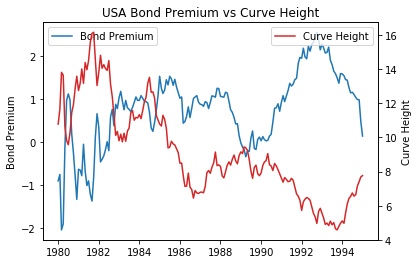

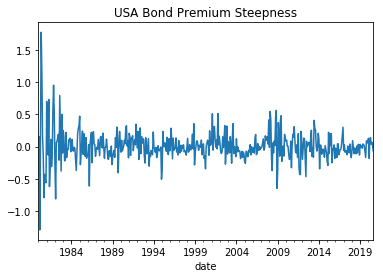

In [9]:
BondPremium = LongRates - ShortRates # reflects the slope of the yield curve
CurveHeight = (LongRates + ShortRates) / 2 # average of short and long-term yields

country = 'USA'
start = '1980-01'
end = '1995-01'

# Bond Premium vs. Curve Height
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(BondPremium[country].loc[pd.Period(start):pd.Period(end)].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Curve Height'
ax2.plot(CurveHeight[country].loc[pd.Period(start):pd.Period(end)].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Premium vs Curve Height')
plt.show()

# Because data is monthly, we can use diff to find Bond Premium steepness
BondPremium[country].diff().plot()
plt.title(f'{country} Bond Premium Steepness')
plt.show()

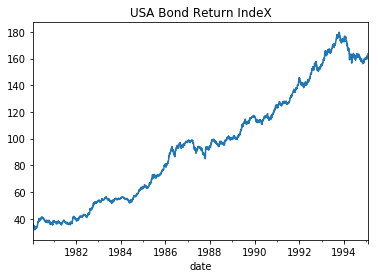

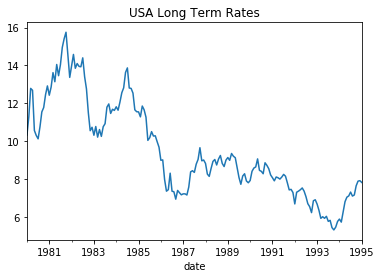

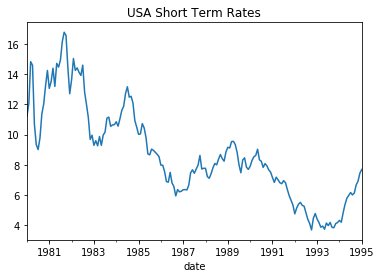

In [10]:
# Exploring Specific Windows
BondReturnIndex[country].loc[pd.Period(start):pd.Period(end)].plot()
plt.title(f'{country} Bond Return IndeX')
plt.show()

LongRates[country].loc[pd.Period(start):pd.Period(end)].plot()
plt.title(f'{country} Long Term Rates')
plt.show()

ShortRates[country].loc[pd.Period(start):pd.Period(end)].plot()
plt.title(f'{country} Short Term Rates')
plt.show()

# MONETARY BASE

Prospectus/Expected relationship:
* Growth in M2 indicates expansionary monetary policy + higher propensity for increase inflation

Exploration steps:
* 1. Build Monetary Base variable
* 2. Compare to short rates

Questions:
* I'm struggling a bit conceptually with comparing M2 and Monetary Base. --> FROM POD OH: The monetary base indicator gives us a sense of M2 growth. Monetary Base tells us roughly how much money is in the system. Based on logical linkages between how much money is in the system and what that means for bond returns, we should be able to determine when to short/long bonds.

In [77]:
# Monetary Base = accumulated change over 3-month vs 12-month periods
ThreeMonthChangeinM2 = M2inUSD.pct_change(2) 
TwelveMonthChangeinM2 = M2inUSD.pct_change(11)
MonetaryBase = (ThreeMonthChangeinM2/TwelveMonthChangeinM2).cumsum()

country = 'FRA'

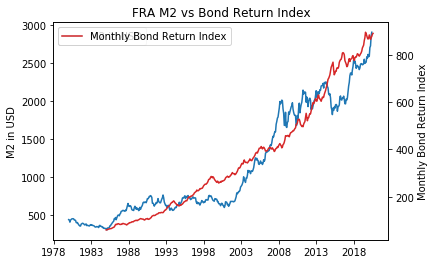

In [78]:
# M2 vs. Monetary Base
# LOGIC: M2 < Monetary Base if we have been growing faster in the past 3 months than in the past year

# M2 vs. Bond Index Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'M2 in USD'
ax1.plot(M2inUSD[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Monthly Bond Return Index'
ax2.plot(MonthlyBondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} M2 vs Bond Return Index')
plt.show()

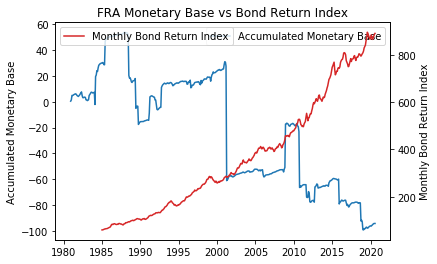

In [79]:
# Monetary Base vs. Bond Index Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Monetary Base'
ax1.plot(MonetaryBase[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Monthly Bond Return Index'
ax2.plot(MonthlyBondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Monetary Base vs Bond Return Index')
plt.show()

# CURRENT ACCOUNT / GDP

Prospectus/Expected relationship:
* Positive current account means country is net exporter
* Countries w/ negative balances can finance themselves w/ sale of sovereign bonds
* Countries w/ persistently negative balances may increase interest rates (or depreciate FX)

Exploration steps:
* 1. Pretty sure CurrAcctPctGDP is this indicator
* 2. Compare to short rates
* 3. Compare to FX Appreciation

Questions
* Not sure how I should think about the sale of sovereign bonds? Intuition is prices would go down as supply goes up--as prices go down yields would go up?

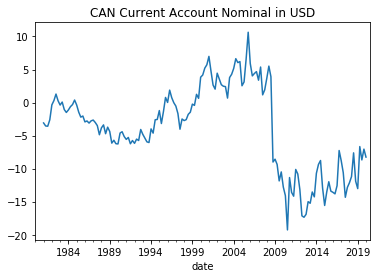

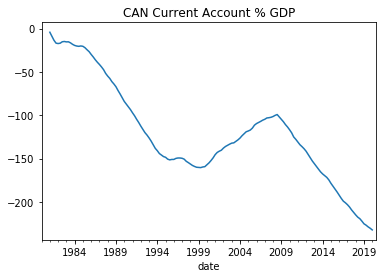

In [14]:
country = 'CAN'

CurrAcctNominUSD[country].plot()
plt.title(f'{country} Current Account Nominal in USD')
plt.show()

CurrAcctPctGDP[country].cumsum().plot()
plt.title(f'{country} Current Account % GDP')
plt.show()

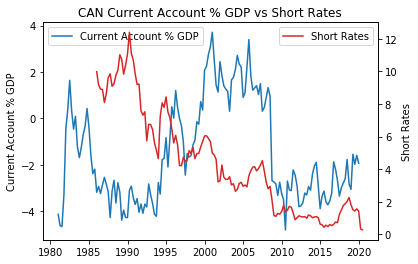

In [15]:
# Monthly short rates --> Quarterly
QuarterlyShortRates = ShortRates.resample('1Q').mean()

# Current Account % GDP vs Short Rates
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Current Account % GDP'
ax1.plot(CurrAcctPctGDP[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Short Rates'
ax2.plot(QuarterlyShortRates[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Current Account % GDP vs Short Rates')
plt.show()

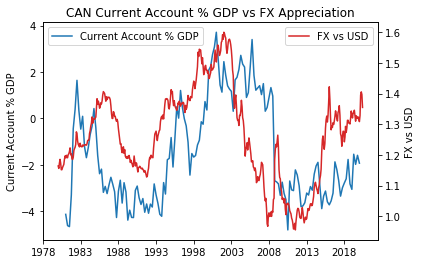

In [16]:
# Current Account % GDP vs FX Appreciation
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Current Account % GDP'
ax1.plot(CurrAcctPctGDP[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'FX vs USD'
ax2.plot(fxVsUSD[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Current Account % GDP vs FX Appreciation')
plt.show()

# FX APPRECIATION

Prospectus/Expected relationship:
* FX Apprectation positively related to bond performance
* With more expensive currency can come lower inflation and lower interest rates

Exploration steps:
* 1. Pretty sure FX Appreciation is itself this indicator
* 2. Compare FX Appreciation and interest rates (short rates)
* 3. Compare FX Appreciation and inflation (??)

Questions
* Not sure how to proxy inflation? From my research online, M2 is not a good proxy. Short rates seem like they could be a lagging indicator of inflation? 

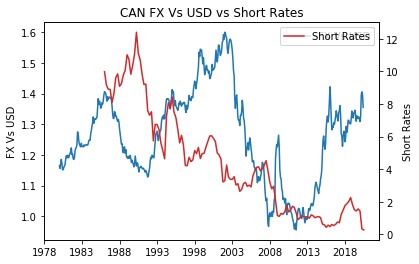

In [17]:
# FX Appreciation vs Short Rates
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'FX Vs USD'
ax1.plot(fxVsUSD[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Short Rates'
ax2.plot(QuarterlyShortRates[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} FX Vs USD vs Short Rates')
plt.show()

In [18]:
# FX Appreciation vs Bond Performance

## I'm still struggling a bit to understand what "bond performance" means. I think it is bond yields. ##

# RELATIVE STOCK/BOND PERFORMANCE

Prospectus/Expected relationship:
* When spread (relative stock/bond performance) is highest, investors will shift to stocks
* If investors are "shifting to stocks," I think equity prices should go up (more demand) and bond prices should go down.

Exploration steps:
* 1. Build Relative Stock/Bond Performance variable
* 2. Compare to Equity Prices (?)

Questions
* Still missing a conceptual bridge about bond "performance." --> FROM POD OH: I think I understand this now. 

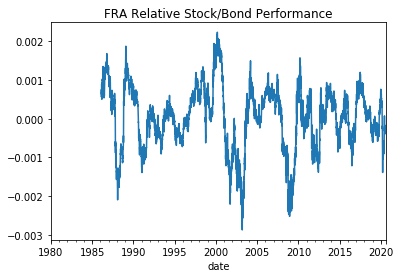

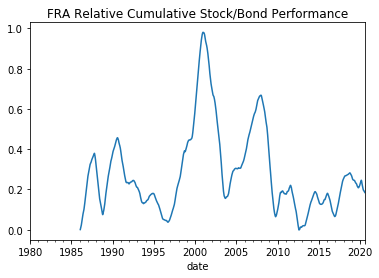

In [80]:
# Calculated as difference between stock and bond returns over last 12 months
StockBondDiff = EquityPrices.pct_change() - BondReturnIndex.pct_change() # not 100% sure this is not apples to oranges
StockBondPerformance = StockBondDiff.rolling(WEEKDAYS_IN_YEAR).mean()

StockBondPerformance[country].plot()
plt.title(f'{country} Relative Stock/Bond Performance')
plt.show()

StockBondPerformance[country].cumsum().plot()
plt.title(f'{country} Relative Cumulative Stock/Bond Performance')
plt.show()

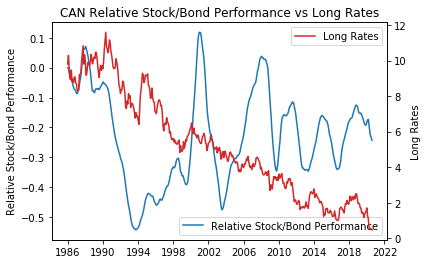

In [20]:
# Stock/Bond Performance vs. Long Rates
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Relative Stock/Bond Performance'
ax1.plot(StockBondPerformance[country].cumsum().to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Long Rates'
ax2.plot(LongRates[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Relative Stock/Bond Performance vs Long Rates')
plt.show()

# CHANGE IN GDP

Prospectus/Expected relationship:
* Strong GDP = equities likely to perform well
* Strong GDP = central bank likely to respond by rising interest rates

Exploration steps:
* 1. Build Change in GDP variable
* 2. Compare to short rates and other measures


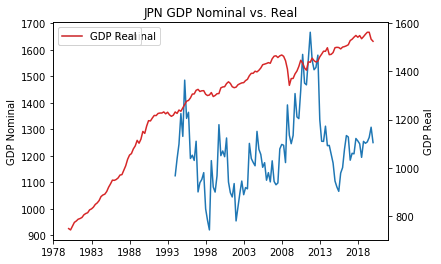

In [21]:
# Taking a look at GDP
country = 'JPN'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'GDP Nominal' # Not sure what currency this is in
ax1.plot(GDPNominal[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'GDP Real' # Inflation adjusted
ax2.plot(GDPReal[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} GDP Nominal vs. Real')
plt.show()

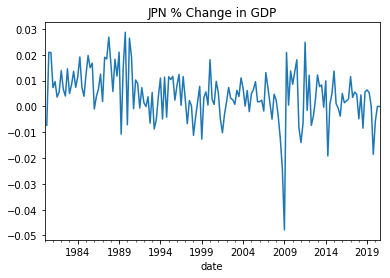

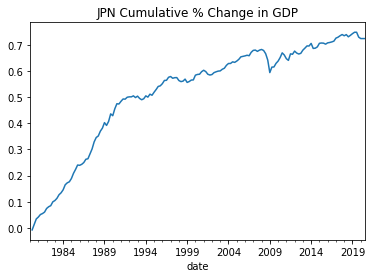

In [22]:
# Change in GDP
ChangeInGDP = GDPReal.pct_change()

ChangeInGDP[country].plot()
plt.title(f'{country} % Change in GDP')
plt.show()

ChangeInGDP[country].cumsum().plot()
plt.title(f'{country} Cumulative % Change in GDP')
plt.show()

# 4. Next Steps

Roadmap

1. Pick 3 indicators. (Or pick just 1? And then add from there?) I am feeling stressed about picking.

--> FROM POD OH: Pick 1. Build this one out. Get through all the way for one country (explore--understand when it does or doesn't do well in terms of telling you to buy and sell bonds). (Leaders suggest I start with Monetary Base)

2. Build end step (like Ollie did). I think this will help solidify my understanding of my goal and to get my brain thinking more concretely about making the indicator into a signal.

3. Go from first indicator to signal. Not sure exactly how to start--here is what I'm thinking.

* I could build a "dashboard" (in Jupyter or even could be in Eikon site) for an indicator. Let's say FX Appreciation. Then I put all the charts that I think are related (everything is related so this seems a little tricky) focusing on "bond performance." Then I could go through each country and see what relationships are holding. 
* As I'm writing this, I'm now thinking a "simpler" way would be to just look at "bond performance" and my indicator. Here is where I start getting a bit jumbled on a math-first vs logic-first approach. My intuition is to try to quantify and scale the relationship between my indicator and "bond performance."

--> FROM POD OH: My thinking for the indicators is to first think directionally (what position, short or long, would it logically make sense for me to take given some country-specific information). Next, to scale the position, I can try to contextualize the country-specific information in that country's history and in what's going on globally. My pod leaders seemed to think this way of thinking about it was ok.

# 5. Updated "Spikeout"

Following Friday Pod OH, I spent some time reviewing and consolidating my understanding of the bond return index and of what bond "performance" means. Then I went back to Monetary Base and (I think) fixed the variable. I tried to get closer to building my indicator. I also went through the other indicators trying to answer my own questions about them.

Indicator: Monetary Base --> accumulated change over 3-month vs 12-month periods

Code from above:
ThreeMonthChangeinM2 = M2inUSD.pct_change(2) 
TwelveMonthChangeinM2 = M2inUSD.pct_change(11)
MonetaryBase = (ThreeMonthChangeinM2/TwelveMonthChangeinM2).cumsum()

Logic: Growth in M2 indicates expansionary monetary policy + higher propensity for increase inflation

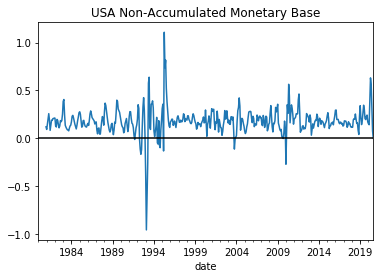

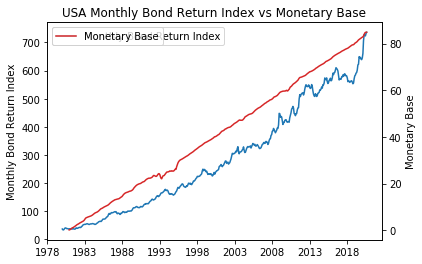

In [82]:
# Monetary Base
country = 'USA'

# LOGIC
# If Non-Accumulated MonetaryBase is > 0, then money supply growth is accelerating (we grew faster in past 3 months compared to past 12 months)
# With growth in MonetaryBase can come expansionary monetary policy and a higher likelihood of increased inflation
# If we think inflation is going to increase, we want a short position
NonAccumulatedMonetaryBase = ThreeMonthChangeinM2/TwelveMonthChangeinM2
NonAccumulatedMonetaryBase[country].plot()
plt.title(f'{country} Non-Accumulated Monetary Base')
plt.axhline(y=0, color='k') # Plotted x axis to clarify positive/negative parts of graph 
plt.show()

# Monetary Base vs Bond Return Index
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Monthly Bond Return Index'
ax1.plot(MonthlyBondReturnIndex[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Monetary Base'
ax2.plot(MonetaryBase[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Monthly Bond Return Index vs Monetary Base')
plt.show()

Analyzing Monetary Base indicator for different countries
* USA: Places where Monetary Base has plateaud (around 2003, 2009) or dipped down (~1993) seem to be immeadiatley followed by dips in Bond Returns.